## Visualizations 

Need to make for ResNet101 and ResNet152:
- Training and Test Loss vs Epoch
- Confusion matrix

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torchvision.models as models
import torch.nn as nn
import random
import seaborn as sns



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


### Training and Test Loss vs Epoch graphs

In [7]:
"""
Import train and test loss .csv files
"""
#import the dataset
res101_losses = pd.read_csv('./output/resnet101_epoch_losses.csv')
res152_losses = pd.read_csv('./output/resnet152_epoch_losses.csv')

#separate train and test losses for each model
res101_train_loss = res101_losses[['Epoch', 'Train Loss']]
res101_test_loss = res101_losses[['Epoch', 'Test Loss']]

res152_train_loss = res152_losses[['Epoch', 'Train Loss']]
res152_test_loss = res152_losses[['Epoch', 'Test Loss']]


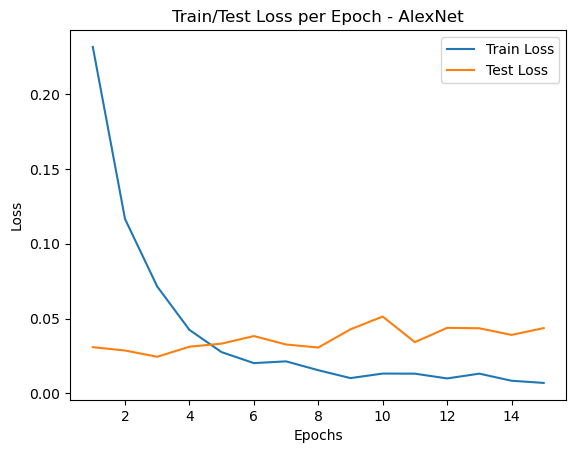

In [15]:
"""
Plot and save the 2 plots for training and testing
"""

## ResNet101 ##
res101_loss_len = len(res101_train_loss)

fig = plt.figure()
plt.plot(np.linspace(1, res101_loss_len, res101_loss_len), res101_train_loss['Train Loss'], label = 'Train Loss')
plt.plot(np.linspace(1, res101_loss_len, res101_loss_len), res101_test_loss['Test Loss'], label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch - AlexNet')
plt.legend()
plt.show()

### Confusion Matrices for ResNet101 and 152

In [4]:
"""
Import trained models and test dataloader
"""

#import trained model and test dataloader

res101 = models.resnet101(weights = None)
res101.fc = nn.Linear(res101.fc.in_features, 5)
res101 = res101.to(device)
res101.load_state_dict(torch.load('./output/resnet101_project_best_shawn.pth'))
res101.eval()

res152 = models.resnet152(weights = None)
res152.fc = nn.Linear(res152.fc.in_features, 5)
res152 = res152.to(device)
res152.load_state_dict(torch.load('./output/resnet152_project_best_shawn.pth'))
res152.eval()


test_loader = torch.load('./output/test_loader.pth')



In [5]:
"""
evaluate it on test dataloader

Evaluation steps from here: 
https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
"""
y_pred101 = []
y_true101 = []
y_pred152 = []
y_true152 = []

for inputs, labels in test_loader:

    inputs, labels = inputs.to(device), labels.to(device)

    output101 = res101(inputs)
    output152 = res152(inputs)
    output101 = (torch.max(torch.exp(output101), 1)[1]).data.cpu().numpy()
    output152 = (torch.max(torch.exp(output152), 1)[1]).data.cpu().numpy()

    y_pred101.extend(output101)
    y_pred152.extend(output152)
    
    labels = labels.data.cpu().numpy()
    y_true101.extend(labels)
    y_true152.extend(labels)

In [6]:
"""
Replace digit labels in the preds and true lists to actual labels for confusion matrix later.

labeling + 1:
1 --> Left Neural Foraminal Narrowing
2 --> Right Neural Foraminal Narrowing
3 --> Left Subarticular Stenosis
4 --> Right Subarticular Stenosis
5 --> Spinal Canal Stenosis
"""

# make mapping of labels for replacing later
label_mapping = {
    0 : 'Left Neural Foraminal Narrowing',
    1 : 'Right Neural Foraminal Narrowing',
    2 : 'Left Subarticular Stenosis',
    3 : 'Right Subarticular Stenosis',
    4 : 'Spinal Canal Stenosis'
}

# replace labels with the mapped labels
y_pred101 = [label_mapping[label] for label in y_pred101]
y_true101 = [label_mapping[label] for label in y_true101]

y_pred152 = [label_mapping[label] for label in y_pred152]
y_true152 = [label_mapping[label] for label in y_true152]




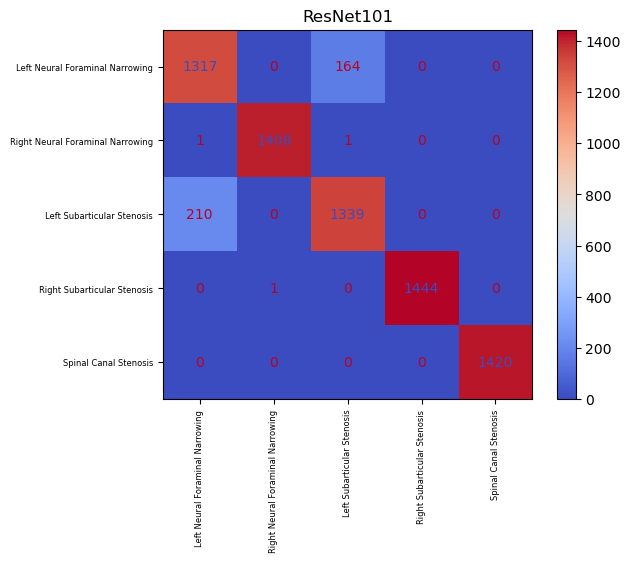

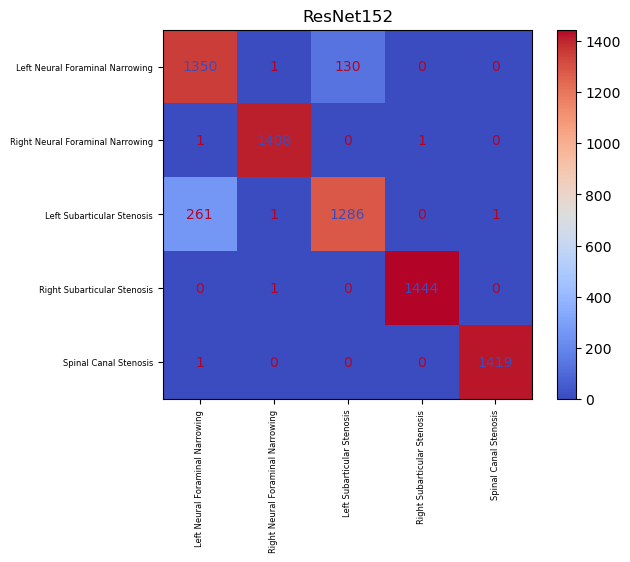

In [8]:
"""
create confusion matrix, then finally save the plot.
"""

classes = [label_mapping[key] for key in sorted(label_mapping)]

conf101 = confusion_matrix(y_true101, y_pred101)
conf101_disp = ConfusionMatrixDisplay(confusion_matrix=conf101, display_labels=classes)


conf152 = confusion_matrix(y_true152, y_pred152)
conf152_disp = ConfusionMatrixDisplay(confusion_matrix=conf152, display_labels=classes)


conf101_disp.plot(cmap = 'coolwarm')
plt.title('ResNet101')
plt.xticks(rotation=90)
plt.xticks(fontsize=6) 
plt.yticks(fontsize=6)
plt.xlabel('')
plt.ylabel('')
conf101_disp.figure_.savefig('./output/resnet101_conf.jpg', dpi=2000, bbox_inches = 'tight')
plt.show()


conf152_disp.plot(cmap = 'coolwarm')
plt.title('ResNet152')
plt.xticks(rotation=90)
plt.xticks(fontsize=6) 
plt.yticks(fontsize=6)
plt.xlabel('')
plt.ylabel('')
conf152_disp.figure_.savefig('./output/resnet152_conf.jpg', dpi=2000, bbox_inches='tight')
plt.show()
